In [54]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
add_folders=["/home/edlitzy/PycharmProjects/UKBB"]
sys.path.extend([x for x in add_folders if x not in sys.path])
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay,PrecisionRecallDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

In [55]:
data_path="/net/mraid08/export/jafar/UKBioBank/Data/Clalit/Clalit_bt.csv"
save_final_df_path="/net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/revision/clalit/scoreboard_results/141121_results.csv"
orig_clalit_df=pd.read_csv(filepath_or_buffer=data_path,index_col="pid")
rel_ind=orig_clalit_df["Reticulocyte Count"].dropna().index
orig_clalit_df=orig_clalit_df.loc[rel_ind,:]

In [56]:
orig_clalit_df

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count
pid,,,,,,,,,,,
3485,2010-09-05,6.0,1946-04-02,0.0,11.0,62.400000,48.0,129.0,NaN,42.076650,0.062400
5277,2011-01-16,5.6,1933-06-04,1.0,31.0,0.052000,41.0,157.0,NaN,37.705050,0.000052
5374,2006-10-29,6.3,1933-03-05,1.0,433.0,19.200001,69.0,65.0,NaN,45.355352,0.019200
6330,2009-02-19,5.1,1935-09-02,0.0,32.0,204.700000,37.0,209.0,2016-05-26,32.240550,0.204700
7918,2011-03-20,5.4,1938-08-26,1.0,81.0,67.000000,51.0,105.0,2017-08-06,35.519250,0.067000
...,...,...,...,...,...,...,...,...,...,...,...
10056438,2010-07-19,6.1,1938-06-13,0.0,15.0,68.000000,35.0,130.0,NaN,43.169550,0.068000
10064594,2011-11-13,5.5,1948-09-08,1.0,97.0,168.000000,39.0,60.0,NaN,36.612150,0.168000
10066521,2011-11-27,5.2,1947-01-29,0.0,71.0,65.600000,32.0,53.0,NaN,33.333450,0.065600


# Convert data to dateime

In [59]:
non_na_ind=orig_clalit_df["diabetes_date"].dropna().index
orig_clalit_df.loc[:,["first_visit","datetime_leida"]]=orig_clalit_df.loc[:,["first_visit","datetime_leida"]].applymap(datetime.fromisoformat)
orig_clalit_df.loc[non_na_ind,["diabetes_date"]]=orig_clalit_df.loc[non_na_ind,["diabetes_date"]].applymap(datetime.fromisoformat)

In [66]:
(((orig_clalit_df["first_visit"]-orig_clalit_df["datetime_leida"])/365.25)>timedelta(days=70)).sum()

1010

In [119]:
clalit_df=orig_clalit_df.copy()
clalit_df=clalit_df.loc[(((clalit_df["first_visit"]-clalit_df["datetime_leida"])/365.25)<=timedelta(days=70)),:]

In [121]:
clalit_df=clalit_df.loc[(((clalit_df["first_visit"]-clalit_df["datetime_leida"])/365.25)>=timedelta(days=40)),:]

# Draw a delta time till return

In [122]:
mean_dt=7.3
sigma=2.3
max_dt=17
min_dt=2
clalit_df["dt_years"]=np.clip(np.random.normal(mean_dt,sigma,size=clalit_df.shape[0]),a_max=max_dt,a_min=min_dt)

In [123]:
def my_relative_delta(row):
    print(row)
    return row["first_visit"].replace(year=row["first_visit"].year + row["dt_years"])

In [124]:
pd.to_timedelta(365*clalit_df["dt_years"], unit='D')
clalit_df["dt_days"]=pd.to_timedelta(365*clalit_df["dt_years"], unit='D')
clalit_df["check_date"]=(clalit_df["first_visit"]+ clalit_df["dt_days"]).clip(upper=datetime.fromisoformat("2019-12-31"))

<AxesSubplot:>

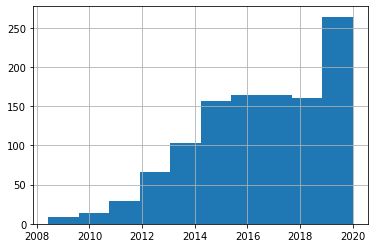

In [125]:
clalit_df["check_date"].hist()

In [126]:
clalit_df["final_dt"]=clalit_df["check_date"]-clalit_df["first_visit"]

<AxesSubplot:ylabel='Frequency'>

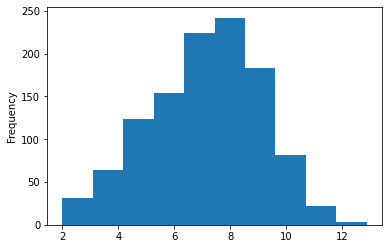

In [127]:
(clalit_df["final_dt"].astype('timedelta64[D]')/365).plot.hist()

In [128]:
(clalit_df["final_dt"].astype('timedelta64[D]')/365).mean()

7.139789121176457

In [129]:
clalit_df["diabetes_date"].isna()

pid
3485         True
11430        True
24485        True
47490        True
52237       False
            ...  
9890555      True
9892371      True
10048398     True
10064594     True
10066521     True
Name: diabetes_date, Length: 1129, dtype: bool

# def check_diagnose

In [130]:
def check_diagnose(row):
#     print(row)
    if type(row["diabetes_date"]) is float:
        return 0
    elif row["diabetes_date"]>row["check_date"]:
        return 0
    elif row["diabetes_date"]<=row["check_date"]:
        return 1
    else:
        return np.nan

In [131]:
clalit_df["Y"]=clalit_df.apply(check_diagnose,axis=1)

# T2D Prevalence at time of test

In [132]:
clalit_df["Y"].sum()/clalit_df.shape[0]

0.21257750221434898

In [133]:
clalit_df.head()

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count,dt_years,dt_days,check_date,final_dt,Y
pid,,,,,,,,,,,,,,,,
3485,2010-09-05,6.0,1946-04-02,0.0,11.0,62.4,48.0,129.0,NaN,42.07665,0.0624,4.948440,1806 days 04:19:56.253475199,2015-08-16 04:19:56.253475199,1806 days 04:19:56.253475199,0
11430,2011-09-18,6.0,1942-04-25,1.0,16.0,74.5,45.0,75.0,NaN,42.07665,0.0745,8.435140,3078 days 19:49:40.453564800,2019-12-31 00:00:00.000000000,3026 days 00:00:00,0
24485,2011-07-10,5.0,1943-02-24,1.0,19.0,107.6,49.0,144.0,NaN,31.14765,0.1076,4.989826,1821 days 06:52:24.066278400,2016-07-04 06:52:24.066278400,1821 days 06:52:24.066278400,0
47490,2008-08-06,6.0,1940-05-27,1.0,32.0,51.5,36.0,94.0,NaN,42.07665,0.0515,8.121133,2964 days 05:07:22.252454400,2016-09-17 05:07:22.252454400,2964 days 05:07:22.252454400,0
52237,2011-12-04,4.3,1950-05-13,1.0,21.0,85.0,40.0,89.0,2012-07-30 00:00:00,23.49735,0.0850,6.389490,2332 days 03:55:46.704863999,2018-04-23 03:55:46.704863999,2332 days 03:55:46.704863999,1


<AxesSubplot:>

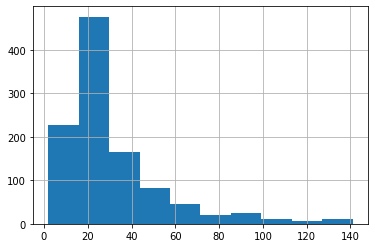

In [134]:
clalit_df.loc[clalit_df["GGT"]<clalit_df["GGT"].quantile(0.95),"GGT"].hist()

In [135]:
clalit_df.columns

Index(['first_visit', 'HbA1c%', 'datetime_leida', 'is_male', 'GGT',
       'Reticulocyte Count', 'HDL', 'Triglycerides', 'diabetes_date',
       'UKB_HbA1c', 'UKB_reticulocyte_count', 'dt_years', 'dt_days',
       'check_date', 'final_dt', 'Y'],
      dtype='object')

In [136]:
clalit_df["UKB_Triglycerides"]=clalit_df["Triglycerides"]*0.01129

In [137]:
clalit_df["UKB_HDL"]=clalit_df["HDL"]*0.02586

In [138]:
rel_cols=[x for x in clalit_df.columns if x!="diabetes_date"]

In [139]:
non_na_ind=clalit_df[rel_cols].dropna(how="any").index

In [140]:
final_df=clalit_df.loc[non_na_ind,:]

In [141]:
final_df.isna().sum()

first_visit                 0
HbA1c%                      0
datetime_leida              0
is_male                     0
GGT                         0
Reticulocyte Count          0
HDL                         0
Triglycerides               0
diabetes_date             822
UKB_HbA1c                   0
UKB_reticulocyte_count      0
dt_years                    0
dt_days                     0
check_date                  0
final_dt                    0
Y                           0
UKB_Triglycerides           0
UKB_HDL                     0
dtype: int64

# Build scoreboard

<AxesSubplot:>

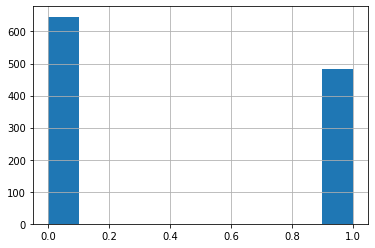

In [142]:
final_df["is_male"].hist()

In [143]:
def check_sex(row):
    if row["is_male"]==1:
        return 4
    elif row["is_male"]==0:
        return 0
    else:
        print("is_male should be 0 or 1")

<AxesSubplot:ylabel='Frequency'>

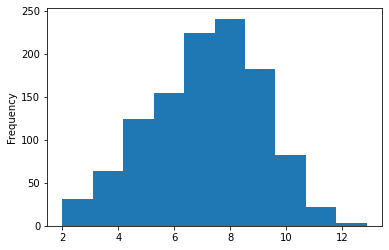

In [144]:
(final_df["final_dt"].astype('timedelta64[D]')/365).plot.hist()

In [145]:
def check_dt(row):
    factor=365
    dt=row["final_dt"]
    if dt<=timedelta(days=factor*5):
        return 0
    elif dt<=timedelta(days=factor*6):
        return 8
    elif dt<=timedelta(days=factor*8):
        return 11
    elif dt<=timedelta(days=factor*9):
        return 12
    elif dt<=timedelta(days=factor*10):
        return 16
    elif dt>timedelta(days=factor*10):
        return 21
    else:
        print("dt must be a timedelta object")
        return None

<AxesSubplot:>

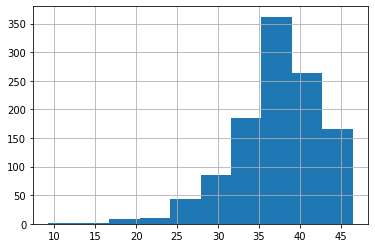

In [146]:
final_df["UKB_HbA1c"].hist()

In [147]:
def check_a1c(row):
    val=row["UKB_HbA1c"]
    if val<=30.7:
        return 0
    elif val<=32.4:
        return 11
    elif val<=33.6:
        return 16
    elif val<=34.6:
        return 18
    elif val<=35.7:
        return 27
    elif val<=36.9:
        return 32
    elif val<=38.5:
        return 39
    elif val>38.5:
        return 58
    else:
        print("a1c is not in any range")
        return None

<AxesSubplot:>

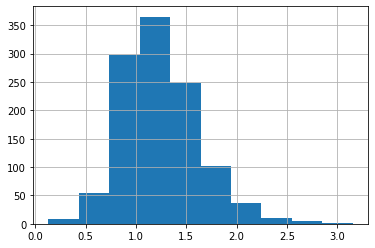

In [148]:
final_df["UKB_HDL"].hist()

In [149]:
def check_hdl(row):
    val=row["UKB_HDL"]
    if val<=1.1:
        return 27
    elif val<=1.3:
        return 19
    elif val<=1.4:
        return 18
    elif val<=1.5:
        return 14
    elif val<=1.6:
        return 12
    elif val<=1.9:
        return 9 
    elif val>1.9:
        return 0
    else:
        print("HDL is not in any range")
        return None

<AxesSubplot:>

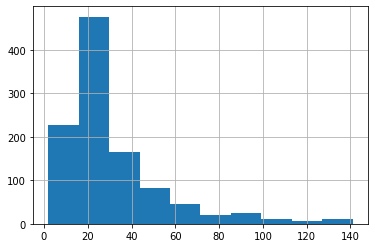

In [150]:
final_df.loc[final_df["GGT"]<final_df["GGT"].quantile(0.95),"GGT"].hist()

In [151]:
def check_ggt(row):
    val=row["GGT"]
    if val<=14.8:
        return 0
    elif val<=18:
        return 7
    elif val<=21.4:
        return 11
    elif val<=25.3:
        return 12
    elif val<=30.4:
        return 16
    elif val<=37.7:
        return 20
    elif val<=53.3:
        return 22
    elif val>53.3:
        return 24
    else:
        print("GGT is not in any range")
        return None

<AxesSubplot:>

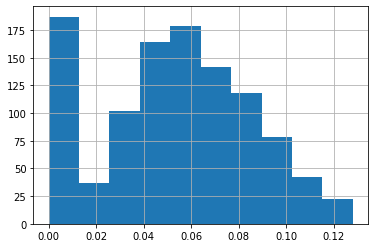

In [152]:
final_df.loc[final_df["UKB_reticulocyte_count"]<final_df["UKB_reticulocyte_count"].quantile(0.95),"UKB_reticulocyte_count"].hist()

In [153]:
def check_reticulocyte(row):
    val=row["UKB_reticulocyte_count"]
    if val<=0.035:
        return 0
    elif val<=0.043:
        return 5
    elif val<=0.051:
        return 7
    elif val<=0.058:
        return 11
    elif val<=0.067:
        return 14
    elif val<=0.081:
        return 17
    elif val>0.081:
        return 22
    else:
        print("reticulocyte is not in any range")
        return None

<AxesSubplot:>

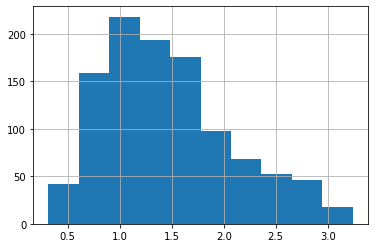

In [154]:
final_df.loc[final_df["UKB_Triglycerides"]<final_df["UKB_Triglycerides"].quantile(0.95),"UKB_Triglycerides"].hist()

In [155]:
def check_triglycerides(row):
    val=row["UKB_Triglycerides"]
    if val<=0.89:
        return 0
    elif val<=1.2:
        return 3
    elif val<=1.4:
        return 4
    elif val<=1.8:
        return 6
    elif val<=2.4:
        return 7
    elif val>2.4:
        return 9
    else:
        print("triglycerides is not in any range")
        return None

In [156]:
def scoreboard_score(row):
#     print(row)
    tot_sum=0
    func_list=[check_sex,check_dt,check_a1c,check_hdl,check_ggt,check_reticulocyte,check_triglycerides]
    for func in func_list:
        tot_sum+=func(row)
    return tot_sum

In [157]:
final_df.isna().sum()

first_visit                 0
HbA1c%                      0
datetime_leida              0
is_male                     0
GGT                         0
Reticulocyte Count          0
HDL                         0
Triglycerides               0
diabetes_date             822
UKB_HbA1c                   0
UKB_reticulocyte_count      0
dt_years                    0
dt_days                     0
check_date                  0
final_dt                    0
Y                           0
UKB_Triglycerides           0
UKB_HDL                     0
dtype: int64

## Save Final DF

In [158]:
final_df["score"]=final_df.apply(scoreboard_score,axis=1)

In [159]:
final_df.to_csv(save_final_df_path)

<AxesSubplot:>

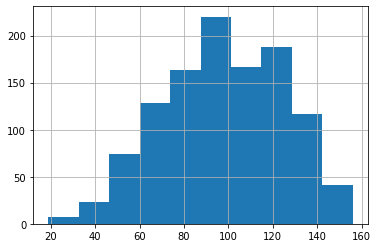

In [160]:
final_df["score"].hist()

In [161]:
final_df.head()

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count,dt_years,dt_days,check_date,final_dt,Y,UKB_Triglycerides,UKB_HDL,score
pid,,,,,,,,,,,,,,,,,,,
3485,2010-09-05,6.0,1946-04-02,0.0,11.0,62.4,48.0,129.0,NaN,42.07665,0.0624,4.948440,1806 days 04:19:56.253475199,2015-08-16 04:19:56.253475199,1806 days 04:19:56.253475199,0,1.45641,1.24128,97
11430,2011-09-18,6.0,1942-04-25,1.0,16.0,74.5,45.0,75.0,NaN,42.07665,0.0745,8.435140,3078 days 19:49:40.453564800,2019-12-31 00:00:00.000000000,3026 days 00:00:00,0,0.84675,1.16370,117
24485,2011-07-10,5.0,1943-02-24,1.0,19.0,107.6,49.0,144.0,NaN,31.14765,0.1076,4.989826,1821 days 06:52:24.066278400,2016-07-04 06:52:24.066278400,1821 days 06:52:24.066278400,0,1.62576,1.26714,73
47490,2008-08-06,6.0,1940-05-27,1.0,32.0,51.5,36.0,94.0,NaN,42.07665,0.0515,8.121133,2964 days 05:07:22.252454400,2016-09-17 05:07:22.252454400,2964 days 05:07:22.252454400,0,1.06126,0.93096,135
52237,2011-12-04,4.3,1950-05-13,1.0,21.0,85.0,40.0,89.0,2012-07-30 00:00:00,23.49735,0.0850,6.389490,2332 days 03:55:46.704863999,2018-04-23 03:55:46.704863999,2332 days 03:55:46.704863999,1,1.00481,1.03440,78


# ROC and APS

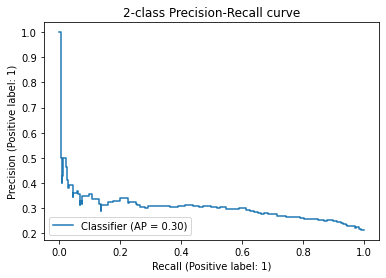

In [162]:
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay
PR_disp=PrecisionRecallDisplay.from_predictions(final_df["Y"],final_df["score"])
_ = PR_disp.ax_.set_title("2-class Precision-Recall curve")

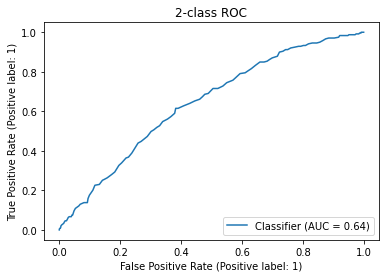

In [163]:
ROC_disp=RocCurveDisplay.from_predictions(final_df["Y"],final_df["score"])
_ = ROC_disp.ax_.set_title("2-class ROC")

In [164]:
final_df.columns

Index(['first_visit', 'HbA1c%', 'datetime_leida', 'is_male', 'GGT',
       'Reticulocyte Count', 'HDL', 'Triglycerides', 'diabetes_date',
       'UKB_HbA1c', 'UKB_reticulocyte_count', 'dt_years', 'dt_days',
       'check_date', 'final_dt', 'Y', 'UKB_Triglycerides', 'UKB_HDL', 'score'],
      dtype='object')

In [165]:
view_df=final_df.loc[:,['first_visit',"diabetes_date",'final_dt','check_date','Y','score']].sort_values(by="score")

In [166]:
final_df=final_df.sort_values(by="score")

In [167]:
final_df.loc[final_df["Y"]==1,:].head(50)

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count,dt_years,dt_days,check_date,final_dt,Y,UKB_Triglycerides,UKB_HDL,score
pid,,,,,,,,,,,,,,,,,,,
4606911,2006-10-05,4.70,1965-06-27,0.0,13.0,0.091700,39.0,146.0,2007-02-09 00:00:00,27.868948,0.000092,4.726958,1725 days 08:09:18.346320,2011-06-26 08:09:18.346320000,1725 days 08:09:18.346320,1,1.64834,1.00854,33
4427284,2008-11-04,4.40,1962-12-31,0.0,12.0,86.700000,54.0,51.0,2012-01-30 00:00:00,24.590250,0.086700,4.123987,1505 days 06:07:49.264060800,2012-12-18 06:07:49.264060800,1505 days 06:07:49.264060800,1,0.57579,1.39644,40
2893236,2009-09-16,4.90,1950-02-12,0.0,13.0,0.071900,37.0,210.0,2013-04-12 00:00:00,30.054750,0.000072,6.198659,2262 days 12:14:57.327158399,2015-11-26 12:14:57.327158399,2262 days 12:14:57.327158399,1,2.37090,0.95682,45
7691140,2008-05-22,5.20,1958-02-11,0.0,39.0,0.092000,58.0,59.0,2008-09-03 00:00:00,33.333450,0.000092,4.458980,1627 days 12:40:04.794787200,2012-11-04 12:40:04.794787200,1627 days 12:40:04.794787200,1,0.66611,1.49988,52
8592118,2009-01-20,5.50,1951-08-20,0.0,22.0,16.800000,78.0,81.0,2014-02-26 00:00:00,36.612150,0.016800,6.388788,2331 days 21:46:50.308348800,2015-06-09 21:46:50.308348800,2331 days 21:46:50.308348800,1,0.91449,2.01708,58
5110727,2011-12-15,5.20,1958-05-20,0.0,25.0,14.000000,57.0,123.0,2013-07-11 00:00:00,33.333450,0.014000,9.365612,3418 days 10:45:40.981708800,2019-12-31 00:00:00.000000000,2938 days 00:00:00,1,1.38867,1.47402,58
4303270,2008-01-03,4.90,1960-09-22,0.0,18.0,89.000000,60.0,208.0,2011-08-17 00:00:00,30.054750,0.089000,7.229129,2638 days 15:10:14.963750400,2015-03-25 15:10:14.963750400,2638 days 15:10:14.963750400,1,2.34832,1.55160,59
9211665,2008-04-30,4.90,1950-11-25,0.0,74.0,54.000000,47.0,74.0,2008-08-13 00:00:00,30.054750,0.054000,5.758828,2101 days 23:19:56.250825600,2014-01-30 23:19:56.250825600,2101 days 23:19:56.250825600,1,0.83546,1.21542,62
8010481,2008-02-25,4.90,1955-09-09,1.0,39.0,0.137200,53.0,173.0,2015-07-19 00:00:00,30.054750,0.000137,8.691372,3172 days 08:25:12.617817600,2016-11-01 08:25:12.617817600,3172 days 08:25:12.617817600,1,1.95317,1.37058,63


In [168]:
final_df.loc[final_df["Y"]==0,:].tail(5)

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count,dt_years,dt_days,check_date,final_dt,Y,UKB_Triglycerides,UKB_HDL,score
pid,,,,,,,,,,,,,,,,,,,
5221852,2009-02-24,5.70,1956-03-31,1.0,174.0,64.0,31.0,96.0,NaN,38.79795,0.0640,10.396571,3794 days 17:57:39.743510400,2019-07-16 17:57:39.743510400,3794 days 17:57:39.743510400,0,1.08384,0.80166,151
5162344,2007-02-28,5.74,1938-05-29,0.0,33.0,82.0,40.0,244.0,NaN,39.23511,0.0820,9.365075,3418 days 06:03:13.200249600,2016-07-08 06:03:13.200249600,3418 days 06:03:13.200249600,0,2.75476,1.03440,152
4364815,2009-05-18,5.70,1961-07-21,0.0,141.0,73.7,40.0,158.0,NaN,38.79795,0.0737,10.605833,3871 days 03:05:41.060284799,2019-12-23 03:05:41.060284799,3871 days 03:05:41.060284799,0,1.78382,1.03440,153
4048043,2009-07-09,5.90,1956-04-13,1.0,334.0,71.0,28.0,88.0,NaN,40.98375,0.0710,11.314560,4129 days 19:32:38.361782399,2019-12-31 00:00:00.000000000,3827 days 00:00:00,0,0.99352,0.72408,154
4141416,2009-03-16,6.10,1957-05-24,1.0,73.0,85.3,25.0,168.0,NaN,43.16955,0.0853,8.857912,3233 days 03:18:23.802681600,2018-01-21 03:18:23.802681600,3233 days 03:18:23.802681600,0,1.89672,0.64650,154
